In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.933276  0.053550 -0.838131  0.934928  0.835574  0.486603 -0.269793   
  1  -0.694500  0.934026 -0.014334  0.161605  0.696375  0.082715 -0.064813   
  2  -1.509849 -0.274068 -0.345126  0.316195  0.302880  0.691539  0.860484   
  3  -1.247969 -0.703006 -0.315169 -0.275065  0.392947  0.200033 -0.109610   
  4  -0.985458  0.086491 -0.906124  0.018434 -0.439511  0.494552  0.101928   
  5   0.688980 -0.121769  0.189951  0.534127  0.141263  0.769931  0.283788   
  6  -0.269127 -0.136534 -1.772236  0.856558  0.148431 -0.192992 -1.125024   
  7  -0.523951  1.043270 -0.445973 -0.268023 -0.594103  0.548829  0.457119   
  8   0.372979 -0.363899 -0.282441  0.787457  0.118310 -0.778295 -0.274969   
  9   0.885904  1.057196 -0.305887 -0.165528 -0.177205  0.336595  0.816825   
  10 -0.889105 -0.712122  0.088580 -0.215803 -0.628602 -0.429483  0.379068   
  11 -0.608165 -1.269580 -0.674380  0.528920  0.285237  0.862626  0.312957   
  12 -0.042445 -0.758964 -0.840794  1.346446  0.337364  0.354465 -0.052456   
  13 -0.473326 -0.232993 -1.028137 -0.500239 -0.224658 -0.063915 -0.581067   
  14 -0.246448 -0.211579 -0.098149 -0.046790  0.106327  0.523994  0.591245   
  15  0.009305 -0.518578 -0.904862 -0.391317  0.623930 -0.166239  0.807734   
  16 -0.310413  0.072011 -1.012378  0.921430  0.391036 -0.499814  0.122958   
  17 -0.733169 -0.517934 -0.416234 -0.774742 -0.098286  0.587072 -0.533996   
  18 -0.620664  0.617260  0.028175  0.236309  0.257099 -0.566266  0.606880   
  19 -1.555804  0.137236 -0.115410  0.529958 -0.172135 -0.071037  0.810978   
  20 -1.130962  0.126876  0.001758  0.154280  0.073834 -0.191377  0.934511   
  21  0.290824 -0.143928 -1.345499  0.984814  0.186187  0.277333  1.142818   
  22  0.098920  1.158850  0.521426  0.021933  0.387724  0.507192 -0.107788   
  23  0.036670 -0.063375  0.172960 -0.073365  0.503914  0.541636  0.135241   
  24 -0.538859 -0.184307 -1.068478  0.075947  0.089297  0.038844  0.080728   
1 0   0.038371 -0.409261  0.051940  0.385498  0.304613 -0.211111 -0.860457   
  1   0.014461  0.900043  0.544906 -0.077334  0.089017  0.359013  0.080309   
  2  -1.184249 -0.009010  0.763577  0.921268  0.395266 -0.257269 -0.586405   
  3  -0.540147 -1.261414 -0.257139  0.629588  0.111167  0.064128  0.784540   
  4  -0.104009  0.293983 -0.478622  0.128199  0.279288  0.281833  0.314833   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.079353  0.107988 -0.882902  ...  1.007937 -0.291185  0.884433   
  1   0.088694 -0.121810 -0.880764  ... -0.070550  0.754782 -0.144786   
  2  -0.147359  0.527286 -0.654513  ...  0.690835  0.328128  0.572422   
  3  -0.152065 -1.396500 -0.561416  ... -0.961475  0.279868 -0.722551   
  4   0.211377 -1.455592  0.153832  ... -0.348937  0.705227  0.768669   
  5  -0.862413 -0.302581 -0.400593  ...  0.801328  0.028066  0.391410   
  6   0.227456 -0.467022  0.149191  ...  0.444062  0.423915 -0.135736   
  7   0.450575  0.369389 -0.569893  ...  0.647761  1.032642 -0.779654   
  8  -0.046351  1.094586  0.046355  ... -0.497371  0.418997 -0.651450   
  9   0.593215  0.139314  0.739354  ... -0.402665 -0.146577 -0.858503   
  10  0.168330  1.882117  0.653909  ...  0.187334  0.937739  0.141958   
  11 -0.269210  0.655808  0.107523  ... -0.349680 -1.224141 -0.456143   
  12 -0.510122  0.230872  0.108613  ... -0.836622  0.298768 -0.694238   
  13  0.090534 -0.671989 -0.095809  ...  0.880155  1.134414  0.059171   
  14  0.704723  0.104447 -0.243361  ...  0.657188  0.213239 -1.016052   
  15  0.171744  0.500432  0.313640  ...  0.338472  0.647036  0.206061   
  16  0.008081  0.972420  0.755412  ...  0.308746 -0.401867 -0.544659   
  17  0.579705  0.005066 -0.701654  ... -0.646621 -0.166174 -0.595830   
  18 -0.652706 -0.548278 -0.799840  ...  1.105110  1.732319 -0.135784   
  19 -0.368290  0.273239 -0.220657  ... -0.656844 -0.101115  0.176056   
  20  0.368939  0.429230 -0.131001  ...  0.545765  0.976656 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.106021  0.043885  25.202475  3.763110e-140  1.020007  1.192035


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



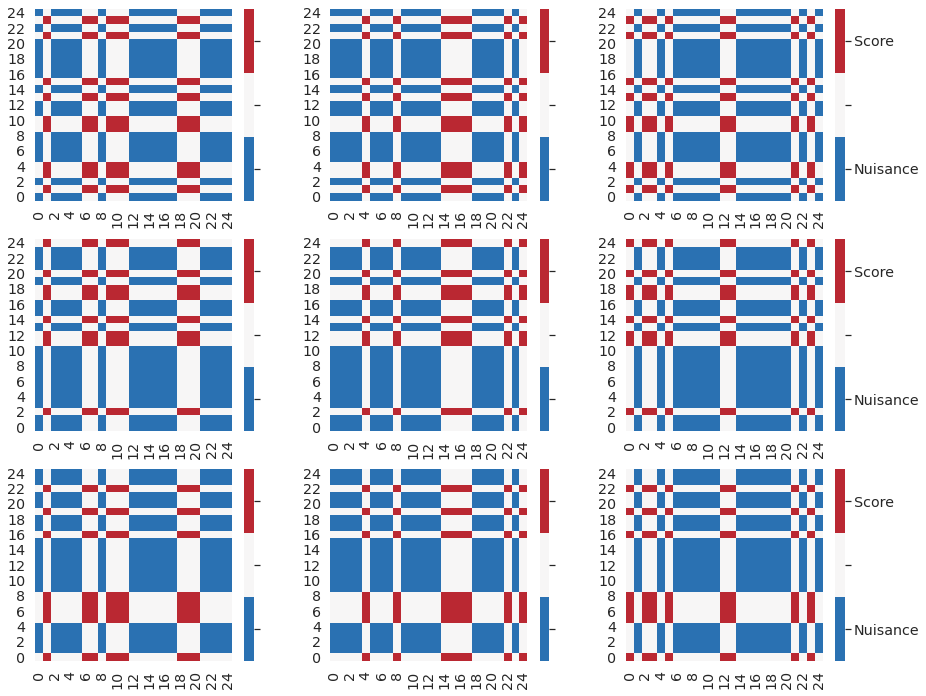

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



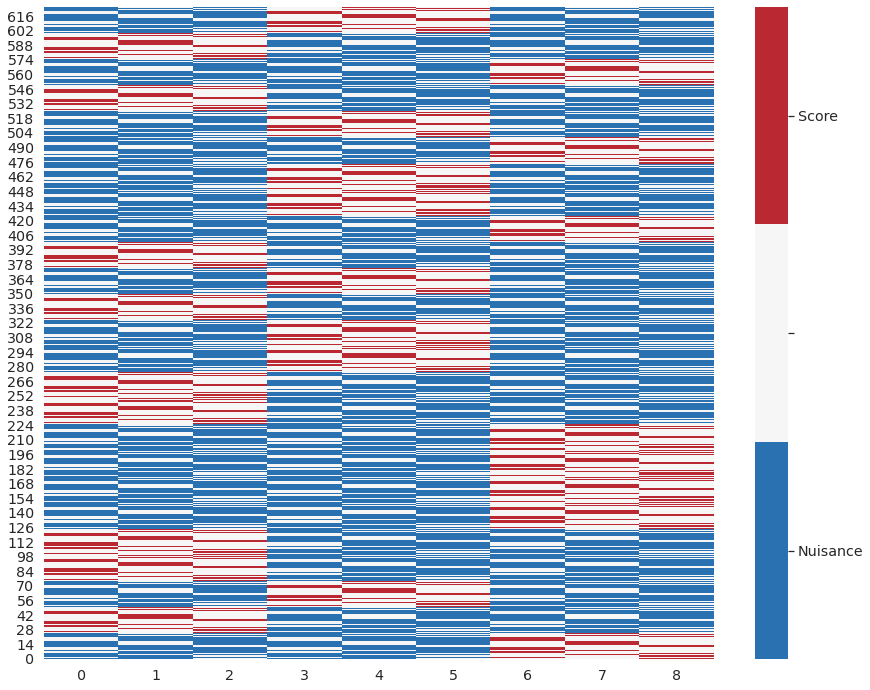

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])